In [3]:
import dominoes
import numpy as np
import matplotlib.pyplot as plt

# Multiagent training: Visualization and Policy Evaluation

In this notebook, we train a multiagent system to play 2v2 dominoes. We visualize the training process and evaluate the trained policies.

We start by training 4 identical Q-Learners.


In [1]:

from dominoes.players import *
from dominoes.q_learner import QLearner
from dominoes.train import train

PLAYERS = [QLearner(), QLearner(), QLearner(), QLearner()]

train(PLAYERS, n=10000, verbose = False)

Done training


# 0. Visualizing the Training error

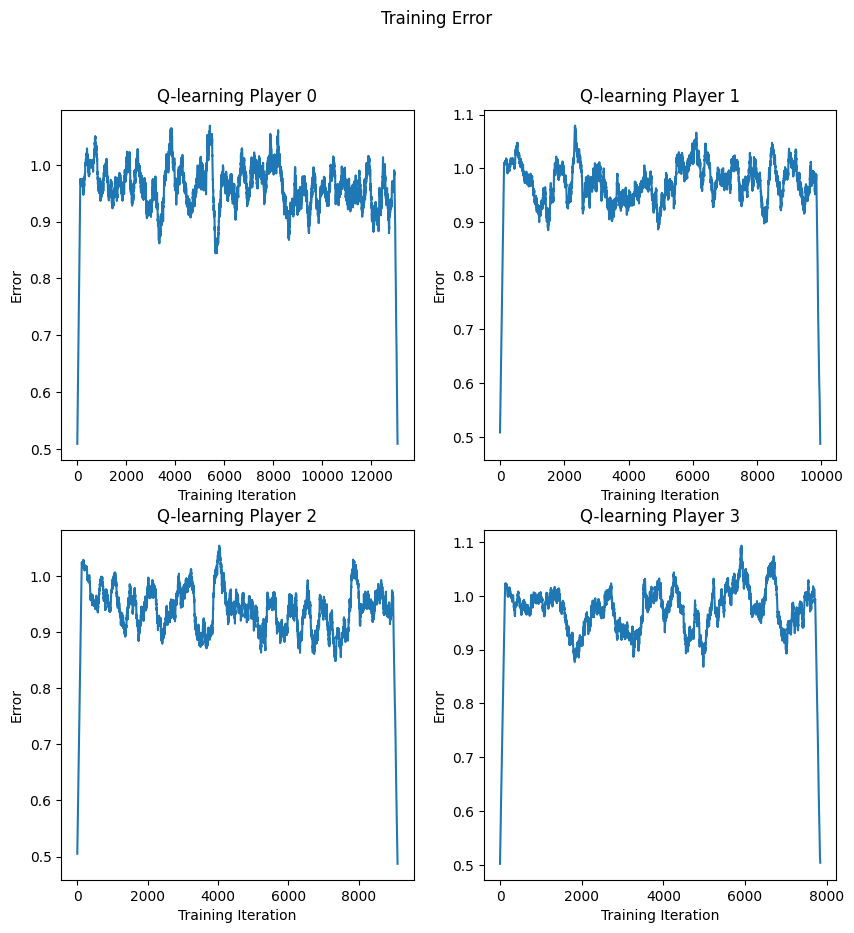

In [6]:
# create a 4 by 4 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# iterate over the players in the PLAYERS list
for i, player in enumerate(PLAYERS):
    # compute and assign a rolling average of the data to provide a smoother graph
    rolling_length = 250
    training_error_moving_average = (
        np.convolve(np.array(player.training_error), np.ones(rolling_length), mode="same")
        / rolling_length
    )

    # plot the training error in a subplot
    axs[i//2, i%2].plot(range(len(training_error_moving_average)), training_error_moving_average)

    # add labels to the axes and set the title of the subplot
    axs[i//2, i%2].set_xlabel("Training Iteration")
    axs[i//2, i%2].set_ylabel("Error")
    axs[i//2, i%2].set_title(player.name + f' {i}')

# set the title of the entire plot
fig.suptitle("Training Error")

# display the plot
plt.show()

# 1. Visualizing the Value function

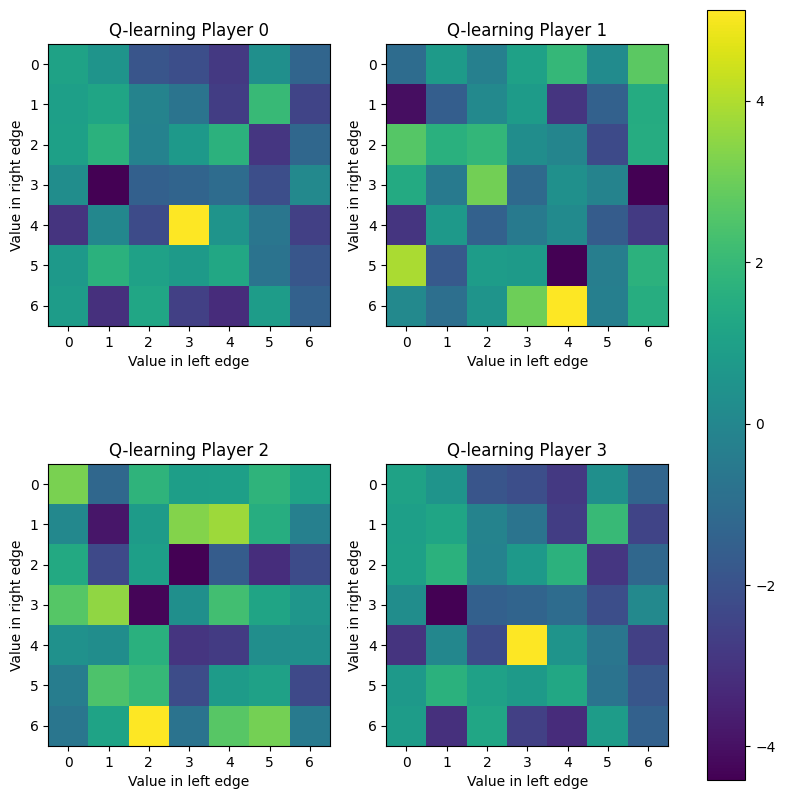

In [7]:
# create a 2 by 2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# iterate over the players in the PLAYERS list
for i, player in enumerate(PLAYERS):
    # convert state-action values to state values
    state_values = dict()
    for key in player.q:
        state = key[0]
        if state not in state_values:
            state_values[state] = player.q[key]
        else:
            state_values[state] += player.q[key]

    # create the value grid for plotting
    value_grid = np.zeros((7,7))
    for key in state_values:
        value_grid[key[0], key[1]] = state_values[key]

    # add labels to the axes
    axs[i//2, i%2].set_xticks(range(7))
    axs[i//2, i%2].set_yticks(range(7))
    axs[i//2, i%2].set_xlabel("Value in left edge")
    axs[i//2, i%2].set_ylabel("Value in right edge")

    # plot the value grid
    axs[i//2, i%2].imshow(value_grid)
    axs[i//2, i%2].set_title(f"{player.name} {i}")

# add a colorbar to the plot
fig.colorbar(axs[0, 0].imshow(value_grid), ax=axs, location='right')

# display the plot
plt.show()

Observations: 
- There is a high variance in the value function. This is because the value function is a sum of the Q-values of all the actions. The Q-values are highly variable because the agents are trained solely on the edges of the board as states.
- P0 and P3, P1 and P2 always have similar value functions.


---

# 2. Benchmarking

In [10]:
def single_game(plyrs):
    """
    automatically runs a single game, with the four players specified 
    in the "player_settings" argument. 
    returns the game object of the played game.
    
    """
    
    single_game = dominoes.Game.new(starting_domino= dominoes.Domino(6,6))

    while single_game.result is None: 
            # remember whose turn it currently is.
            # we'll need it after we move on to the next player.
            turn = single_game.turn

            # get the setting for the current player
            plyr = plyrs[single_game.turn]

            # the current player is an AI. apply the player setting to select a
            # move to play and make the selected move
            plyr(single_game)
            single_game.make_move(*single_game.valid_moves[0])
    
    return single_game

the next block of code runs a certain number of iterations of the same faceoff between two teams, recording which team won (not by how much). The results are stored in a tuple. The results should be balanced

In [9]:
def simulate_games(plyrs, n = 100):
    """
    simulates n games with the four players specified in the "plyrs" argument. 
    returns a list of game objects of the played games.
    
    """
    games = []
    for i in range(n):
        games.append(single_game(plyrs).result.points)
    
    # create mask over games.points if greater than 0. then count
    # number of True values in mask
    win_count = sum([1 for i in games if i > 0])
    print("Team 0 won " + str(win_count) + " out of " + str(n) + " games.")
    return games

Let's run some simulations!

- i) Random players all around (sanity check)
- ii) Q-Learners vs Random Players

In [37]:
PLAYER_SETTINGS_0 = [dominoes.players.RandomPlayer(), dominoes.players.RandomPlayer(), dominoes.players.RandomPlayer(), dominoes.players.RandomPlayer()]

In [41]:
games = simulate_games(PLAYER_SETTINGS_0, n = 10_000)

Team 0 won 4929 out of 10000 games.


In [42]:
PLAYER_SETTINGS_1 = [dominoes.players.RandomPlayer(), PLAYERS[1], dominoes.players.RandomPlayer(), PLAYERS[3]]

In [43]:
games = simulate_games(PLAYER_SETTINGS_1, n = 10_000)

Team 0 won 4918 out of 10000 games.


In [44]:
PLAYER_SETTINGS_2 = [PLAYERS[0], dominoes.players.RandomPlayer(), PLAYERS[0], dominoes.players.RandomPlayer()]

In [45]:
games = simulate_games(PLAYER_SETTINGS_2, n = 10_000)

Team 0 won 4909 out of 10000 games.


Q-Learners seem to perform *marginally* better